In [1]:
import numpy as np
from numpy import pi as π
from numpy.fft import rfft, irfft, rfftfreq
from scipy.integrate import odeint

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
plt.rcParams['font.size'] = 18

In [2]:
c = 2    # Wave speed
L = 20   # Length of domain
N = 1000 # Number of discretization points
dx = L / N
x = np.arange(-L/2, L/2, dx) # Define x domain

# Define discrete wavenumbers
κ = 2*π * rfftfreq(N, d=dx)

# Initial condition (u = sech(x))
u0 = 1 / np.cosh(x)
# Initial condition in (spatial) frequency domain
û0 = rfft(u0)

# Simulate in (spatial) frequency domain
dt = 0.025
t = np.arange(0, 100*dt, dt)

# Right hand side of Wave Equation in (spatial) frequency domain
def rhs_wave(û_f64, t, κ, c):
    û = û_f64.view(np.complex128)
    dû = -c * 1j * κ * û
    return dû.view(np.float64)

# Integrate in frequency domain; views as real since odeint doesn't support complex
û = odeint(
    rhs_wave,
    û0.view(dtype=np.float64),
    t,
    args=(κ, c)
).view(np.complex128)

# Inverse FFT to bring back to spatial domain
u_fdomain = irfft(û, axis=-1)


# Alternatively, simulate in spatial domain, using fft just for spectral derivative
def rhs_wave_spatial(u, t, κ, c):
    û = rfft(u)
    dû =  1j * κ * û
    du = irfft(dû)
    return -c * du

u_sdomain = odeint(rhs_wave_spatial, u0, t, args=(κ, c))

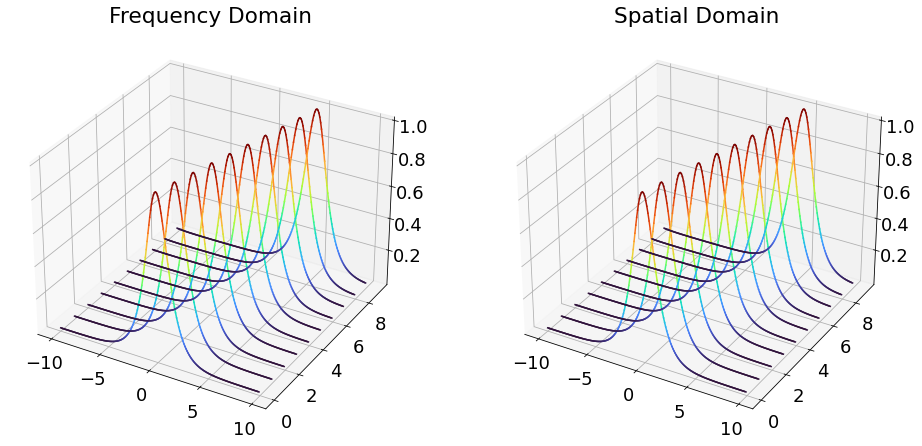

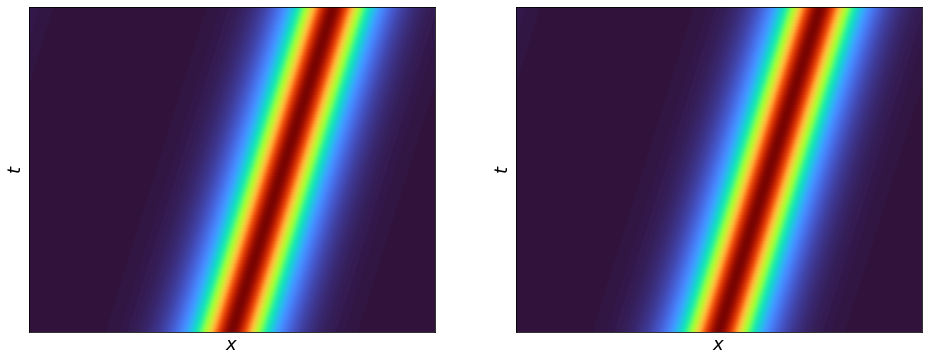

In [3]:
# Waterfall plots
# Figure 2.18
def plot_coloured_line(ax, x, y, z, cmap=plt.cm.turbo, nsteps=200):
    z_normed = (z - z.min()) / (z.max() - z.min())
    step = len(z) // nsteps
    steps = np.arange(0, len(z), step)
    for start, stop in zip(steps[:-1], steps[1:]):
        ax.plot(
            x[start:stop+1],
            y[start:stop+1],
            z[start:stop+1],
            color=cmap(z_normed[(start+stop)//2])
        )

fig, axs = plt.subplots(1, 2, figsize=(16, 8), subplot_kw=dict(projection='3d'))

u_fdomain_plot = u_fdomain[0:-1:10, :]
for j in range(u_fdomain_plot.shape[0]):
    ys = j * np.ones(u_fdomain_plot.shape[1])
    plot_coloured_line(axs[0], x, ys, u_fdomain_plot[j, :])
    axs[0].set_title('Frequency Domain')

u_sdomain_plot = u_sdomain[0:-1:10, :]
for j in range(u_sdomain_plot.shape[0]):
    ys = j * np.ones(u_sdomain_plot.shape[1])
    plot_coloured_line(axs[1], x, ys, u_sdomain_plot[j, :])
    axs[1].set_title('Spatial Domain')


# Image plots
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(np.flipud(u_fdomain), aspect=8, cmap='turbo')
axs[0].axes.xaxis.set_ticks([])
axs[0].axes.yaxis.set_ticks([])
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$t$')
axs[1].imshow(np.flipud(u_sdomain), aspect=8, cmap='turbo')
axs[1].axes.xaxis.set_ticks([])
axs[1].axes.yaxis.set_ticks([])
axs[1].set_xlabel('$x$')
axs[1].set_ylabel('$t$');